# Отчёт по лабораторной работе №3 "Переобучение и регуляризация"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.seterr(all='ignore')


DATA_FILE_NAME_1 = 'Lab 3/ex3data1'

Imports from 'common' file:

In [2]:
import os
from scipy.io import loadmat

DATA_DIRECTORY = '../Data/'


def load_data_from_mat_file(filename, directory=DATA_DIRECTORY):
    filepath = directory + f'{filename}.mat'
    return loadmat(filepath)

def __convert_to_2d(X):
    try:
        X.shape[1]
        return X, False
    except IndexError:
        return np.array([X]).T, True


def extend_x(X):
    X, transposed = __convert_to_2d(X)
    return np.concatenate((np.array([np.ones(X.shape[0])]).T, X), axis=1)


def normalize_features(X):
    delta = X.max(axis=0) - X.min(axis=0)
    average = X.sum(axis=0) / len(X)
    normalized = (X - average) / delta
    return normalized

### 1. Загрузите данные ​ ex3data1.mat ​ из файла.

In [3]:
df_data = load_data_from_mat_file(DATA_FILE_NAME_1)
XY = pd.DataFrame({'x': df_data['X'][:, 0], 'y': df_data['y'][:, 0]})
sorted_XY = XY.sort_values(by=['x'])
X = sorted_XY['x'].values
E_X = extend_x(X)
Y = sorted_XY['y'].values

XYval = pd.DataFrame({'x': df_data['Xval'][:, 0], 'y': df_data['yval'][:, 0]})
sorted_XYval = XYval.sort_values(by=['x'])
Xval = sorted_XYval['x'].values
E_Xval = extend_x(Xval)
Yval = sorted_XYval['y'].values

XYtest = pd.DataFrame({'x': df_data['Xtest'][:, 0], 'y': df_data['Xtest'][:, 0]})
sorted_XYtest = XYtest.sort_values(by=['x'])
Xtest = sorted_XYtest['x'].values
E_Xtest = extend_x(Xtest)
Ytest = sorted_XYtest['y'].values

### 2. Постройте график, где по осям откладываются X и y из обучающей выборки.

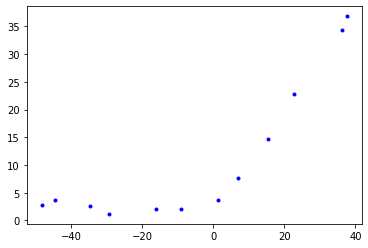

In [4]:
plt.plot(X, Y, 'b.')
plt.show()

### 3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.

In [5]:
def linear_regression_hypotesis(T, X):
    return X.dot(T)


def cost_function_with_reg(H, Y, R):
    return (np.square(H - Y).sum() + R.sum()) / 2 / Y.size


def get_cost_function_with_reg(X, Y, reg_param):
    def func(T):
        H = linear_regression_hypotesis(T, X)
        R = np.square(T[1:]) * reg_param
        return cost_function_with_reg(H, Y, R)
    return func

### 4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.

In [6]:
def gradient_function_with_reg(X, Y, H, R):
    return ((H - Y).dot(X) + R) / len(Y)


def get_gradient_function_with_reg(X, Y, reg_param):
    def func(T):
        H = linear_regression_hypotesis(T, X)
        R = T * reg_param
        R[0] = 0
        return gradient_function_with_reg(X, Y, H, R)
    return func


def gradient_descent_function_with_reg(T, X, Y, learning_rate, reg_param, eps, iteration_count):
    iteration = 0
    theta_gradient = [eps + 1]

    while any([abs(t) > eps for t in theta_gradient]) and iteration < iteration_count:
        H = linear_regression_hypotesis(T, X)
        R = T * reg_param
        R[0] = 0
        theta_gradient = gradient_function_with_reg(X, Y, H, R)
        # print(theta_gradient)
        T -= learning_rate * theta_gradient
        iteration += 1

    return T, not any([abs(t) > eps for t in theta_gradient]), iteration

### 5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?

L2 regularization:
theta [13.077590035486647, 0.36771737547751454]
success True
iteration 72881 



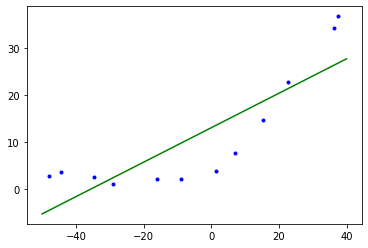

In [7]:
T0 = np.ones(E_X.shape[1])
learning_rate = 1.0e-4
reg_param = 0
eps = 1e-2
iteration_count = 1.0e5
theta, success, iteration = gradient_descent_function_with_reg(T0, E_X, Y, learning_rate,
                                                               reg_param, eps, iteration_count)

print('L2 regularization:')
print('theta', list(theta))
print('success', success)
print('iteration', iteration, '\n')

x = np.arange(-50, 40, 0.1)
e_x = extend_x(x)
y = linear_regression_hypotesis(theta, e_x)
plt.plot(x, y, 'g')
plt.plot(X, Y, 'b.')
plt.show()

В данном случае регуляризация не сработает, т.к. при коэфиценте регуляризация равном нулю функция стоимости и функция градиента приобретают изначальный вид, как при обычной линейной регрессии, т.е. дополнительные
слагаемые в этих функциях не играют никакой роли, так как они равны нулю.

График показывает, что простая линейная регрессия (полином 1-й степени) не подходит для этой задачи.

### 6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?

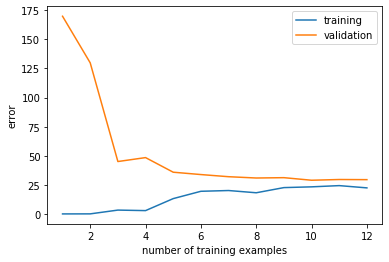

In [9]:
def get_learning_curves(training_sets, validation_set, initials={}):
    training_errors = {}
    validation_errors = {}
    eps = initials.get('eps') or 1e-2
    reg_param = initials.get('reg_param') or 0
    learning_rate = initials.get('learning_rate') or 1.0e-4
    iteration_count = initials.get('iteration_count') or 1.0e5

    e_xval = extend_x(validation_set['x'])
    for training_set in training_sets:
        T0 = initials.get('t0') or np.ones(training_set['x'].shape[1])

        theta, success, iteration = gradient_descent_function_with_reg(
            T0, training_set['x'], training_set['y'], learning_rate, reg_param, eps, iteration_count)

        set_length = len(training_set['y'])
        cost_function = get_cost_function_with_reg(training_set['x'], training_set['y'], reg_param)
        training_errors[set_length] = cost_function(theta)

        cost_function = get_cost_function_with_reg(e_xval, validation_set['y'], reg_param)
        validation_errors[set_length] = cost_function(theta)

    return training_errors, validation_errors


e_x = extend_x(XY['x'])
training_sets = [{'x': e_x[:count], 'y': XY['y'][:count].values} for count in range(1, len(XY['y']) + 1)]
training_errors, validation_errors = get_learning_curves(training_sets, XYval)

plt.plot(list(training_errors.keys()), list(training_errors.values()), label='training')
plt.plot(list(validation_errors.keys()), list(validation_errors.values()), label='validation')
plt.xlabel("number of training examples")
plt.ylabel("error")
plt.legend(loc="best")
plt.show()

Исходя из графика можно сделать вывод, что ошибка (значение функции потерь) ни на обучающей, ни на тренировочной выборке не была уменьшена в достаточной степени. Это значит, что модель недообучена (high bias problem).

### 7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X^2, X^3, X^4, ..., X^p).

In [10]:
def extend_x_by_p(X, p, x_index=1):
    try:
        X.shape[1]
    except IndexError:
        X = np.array([X]).T
        x_index = 0

    x1 = X[:, x_index]
    new_features = np.array([np.power(x1, i) for i in range(2, p + 1)])
    return np.concatenate((X, new_features.T), axis=1)

### 8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

In [11]:
norm_X = normalize_features(X)
norm_Xval = normalize_features(Xval)

In [13]:
p = 8
extend_x_by_p(extend_x(norm_X), p).shape

(12, 9)

### 9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [14]:
p = 8
e_x = extend_x_by_p(extend_x(norm_X), p)
T0 = np.ones(e_x.shape[1])
iteration_count = 1.0e7
learning_rate = 1.0e0
reg_param = 0
eps = 1e-4

training_params = {
    'iteration_count': iteration_count,
    'learning_rate': learning_rate,
    'reg_param': reg_param,
    'eps': eps
}
theta, success, iteration = gradient_descent_function_with_reg(T0, e_x, Y, **training_params)

print('Linear regression with L2 regularization:')
print('p:', p)
print('iteration:', iteration)
print('success:', success)
print('theta:', list(theta), '\n')

Linear regression with L2 regularization:
p: 8
iteration: 1172332
success: True
theta: [2.3976281972240243, 20.877978339163388, 110.17518433337685, 119.59028460353325, -143.67635283592296, -270.1555284961663, -75.91538621311703, -55.41494756476012, -25.051377255801746] 



### 10.Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

Строим график модели, совмещенный с обучающей выборкой

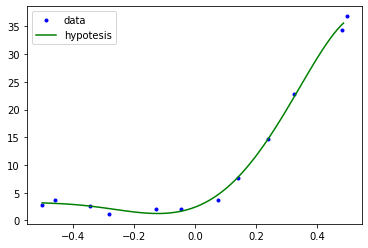

In [15]:
plt.plot(norm_X, Y, 'b.', label='data')
x = np.arange(np.min(norm_X), np.max(norm_X), 0.01)
y = linear_regression_hypotesis(theta, extend_x_by_p(extend_x(x), p))
plt.plot(x, y, 'g', label='hypotesis')
plt.legend()
plt.show()

График процесса обучения:

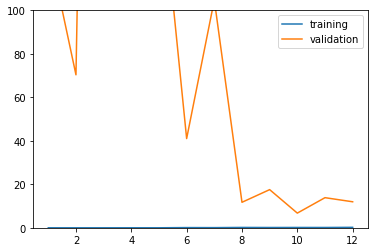

In [16]:
training_sets = [{'x': e_x[:count], 'y': Y[:count]} for count in range(1, len(Y) + 1)]
validation_set = {'x': extend_x_by_p(norm_Xval, p), 'y': Yval}

training_errors, validation_errors = get_learning_curves(training_sets, validation_set, training_params)

plt.plot(list(training_errors.keys()), list(training_errors.values()), label='training')
plt.plot(list(validation_errors.keys()), list(validation_errors.values()), label='validation')
plt.legend()
plt.ylim(0, 100)

plt.show()

Ошибка на обучающей выборке приблизительно равна нулю, а на валидационной выборке не может сойтись. Это
говорит о том, что в данном случае мы наблюдаем переобучение модели (high variance problem).

### 11.Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?

Linear regression with L2 regularization:
p 8
reg_param 1
theta [10.435414254420182, 17.64075202349681, 6.62218268291385, 3.7599621637649183, 1.671960185496506, 0.8539362609821405, 0.40427118642707544, 0.2007535319640372, 0.09750489761838495]
success True
iteration 90 



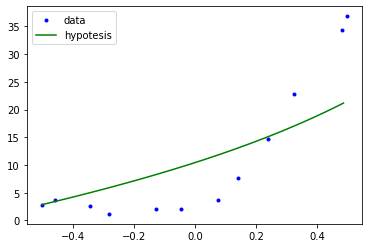

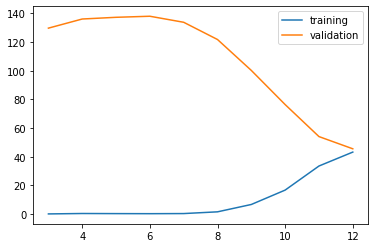

Linear regression with L2 regularization:
p 8
reg_param 100
theta [11.20891680472989, 0.41870659666711463, 0.07338934844438817, 0.08466400078978699, 0.01904107093789282, 0.018896061619959395, 0.004693150059697766, 0.0044009661803119954, 0.0011450187514441806]
success True
iteration 25383 



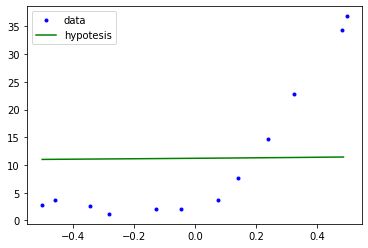

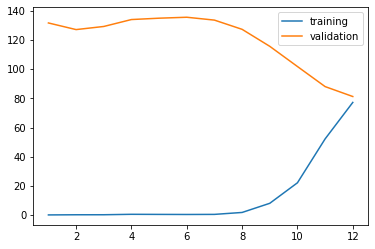

In [17]:
def plot_graphs(x, y, xval, yval, initials={}):
    p = initials.get('p', 8)
    e_x = extend_x_by_p(extend_x(x), p)
    T0 = initials.get('T0', np.ones(e_x.shape[1]))
    params = {
        'iteration_count': initials.get('iteration_count', 1.0e5),
        'learning_rate': initials.get('learning_rate', 1e-1),
        'reg_param': initials.get('reg_param', 0),
        'eps': initials.get('eps', 1e-4),
    }

    theta, success, iteration = gradient_descent_function_with_reg(T0, e_x, y, **params)

    print('Linear regression with L2 regularization:')
    print('p', p)
    print('reg_param', params.get('reg_param'))
    print('theta', list(theta))
    print('success', success)
    print('iteration', iteration, '\n')

    plt.plot(x, y, 'b.', label='data')
    _x = np.arange(np.min(x), np.max(x), 0.01)
    _y = linear_regression_hypotesis(theta, extend_x_by_p(extend_x(_x), p))
    plt.plot(_x, _y, 'g', label='hypotesis')
    plt.legend()
    plt.show()
    
    training_sets = [{'x': e_x[:count], 'y': y[:count]} for count in range(1, len(y) + 1)]
    validation_set = {'x': extend_x_by_p(xval, p), 'y': yval}
    training_errors, validation_errors = get_learning_curves(training_sets, validation_set, params)

    plt.plot(list(training_errors.keys()), list(training_errors.values()), label='training')
    plt.plot(list(validation_errors.keys()), list(validation_errors.values()), label='validation')
    plt.legend()

    plt.show()


plot_graphs(norm_X, Y, norm_Xval, Yval, initials={'reg_param': 1, 'eps': 1e-6, 'learning_rate': 1.5})
plot_graphs(norm_X, Y, norm_Xval, Yval, initials={'reg_param': 100, 'eps': 1e-10, 'learning_rate': 1e-3})

Таким образом добавляется регуляризация в модель. При коэфициенте равном 1 график модели стал более
сглаженным, а значит модель не переобучается. Однако ошибка всё ещё большая. Это значит можно подобрать
лучший коэфициент регуляризации.

При коэфициенте равном 100 график модели стремится к горизонтальной прямой. Это связано с тем что на все веса
кроме θ0 накладывается большой штраф, поэтому они стремятся к нулю, а функция стоимости стоимости стремится к
θ0.

### 12.С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

min error with reg_param: 0.0


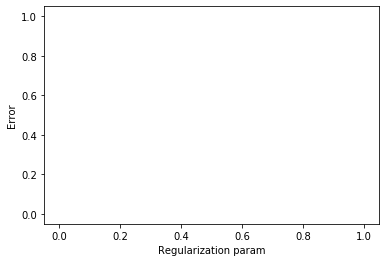

In [38]:
learning_rate = 1e-17
eps = 1e-4
iteration_count = 1.0e7
params = {
    'iteration_count': 1.0e5,
    'learning_rate': 1e-1,
    'eps': 1e-4,
}

reg_errors = {}
thetas_hash = {}
for reg_param in np.arange(0, 1, 0.1):
    theta, success, iteration_count = gradient_descent_function_with_reg(
        T0, e_x, Y, reg_param=reg_param, **params)
    thetas_hash[reg_param] = theta

    cost_function = get_cost_function_with_reg(extend_x_by_p(extend_x(norm_Xval), p), Yval, reg_param)
    reg_errors[reg_param] = cost_function(theta)

min_reg_param = min(reg_errors, key=reg_errors.get)
print('min error with reg_param:', min_reg_param)
plt.plot(list(reg_errors.keys()), list(reg_errors.values()))
plt.xlabel('Regularization param')
plt.ylabel('Error')
plt.show()

### 13.Вычислите ошибку (потерю) на контрольной выборке.

In [19]:
norm_Xtest = normalize_features(Xtest)
Ytest = normalize_features(Ytest)
reg_param = min_reg_param

cost_function = get_cost_function_with_reg(extend_x_by_p(extend_x(norm_Xtest), p), Ytest, reg_param)
print('cost error:', cost_function(thetas_hash[reg_param]))

cost error: nan
